In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.dates as dates
import obspy
import obspy.signal.trigger as trigger
from hydrophone_data_processing import load, useful_variables, plotting, signal_processing
import event_detector_pipeline as edp
from ast import literal_eval

hydrophone_metadata = {
    'h1':{
        # start and end identifies the start time of the swarm where the amplitude magnitude is the highest
        'start':obspy.UTCDateTime('2019-05-21T07:35:00Z')
        ,'end':obspy.UTCDateTime('2019-5-21T07:48:00Z')
       # obspy_idx is the index within the stream for this data (all data is sorted from top to bottom of the borehole this way in lists)
        ,'obspy_idx':0
        # depth of the hydrophone
        ,'depth':30
        ,'velocity_model':1750
    }
    ,    'h2':{
        'start':obspy.UTCDateTime('2019-05-21T07:35:00Z')
        ,'end':obspy.UTCDateTime('2019-5-21T07:48:00Z')
        ,'obspy_idx':1
        ,'depth':100        
        ,'velocity_model':1750

    }
    ,    'h3':{
        'start':obspy.UTCDateTime('2019-05-21T07:35:00Z')
        ,'end':obspy.UTCDateTime('2019-5-21T07:48:00Z')
        ,'obspy_idx':2
        ,'depth':170        
        ,'velocity_model':1750

    }
    ,'h4':{
        'start':obspy.UTCDateTime('2019-05-21T07:48:00Z')
        ,'end':obspy.UTCDateTime('2019-5-21T08:07:00Z')
        ,'obspy_idx':3
        ,'depth':240
        ,'velocity_model':1750
    }
    ,'h5':{
        'start':obspy.UTCDateTime('2019-05-21T08:07:00Z')
        # ,'end':obspy.UTCDateTime('2019-5-21T08:34:00Z')
        ,'end':obspy.UTCDateTime('2019-5-21T08:38:00Z')
        ,'obspy_idx':4
        ,'depth':310
        ,'velocity_model':1750
    }
    ,'h6':{
        'start':obspy.UTCDateTime('2019-05-21T08:34:00Z')
        ,'end':obspy.UTCDateTime('2019-5-21T08:38:00Z')
       ,'obspy_idx':5
        ,'depth':380
        ,'velocity_model':1750
    }
}

In [2]:
df = pd.read_csv('precision.csv')
# df['aic_t'] = df.aic_t.apply(lambda x: literal_eval(x))
# df['aics'][5][7:-2].replace('\n','')
df['aic_t'] = df['aic_t'].apply(literal_eval)
df['aics'] = np.array(df['aics'].apply(literal_eval))
df['aic_maxes'] = df['aic_maxes'].apply(literal_eval)

In [3]:
paths = useful_variables.make_hydrophone_data_paths(borehole='a', year=2019, julian_day=141)
waveforms = load.import_corrected_data_for_single_day(paths=paths)
swarm_starttime = obspy.UTCDateTime('2019-05-21T07:30:00')
swarm_endtime = obspy.UTCDateTime('2019-05-21T08:38:30')
waveforms = waveforms.trim(starttime=swarm_starttime, endtime=swarm_endtime)

/home/john/anaconda3/envs/borehole/lib/python3.8/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (500) of bandpass is at or above Nyquist (500.0). Applying a high-pass instead.
  warnings.warn(msg)


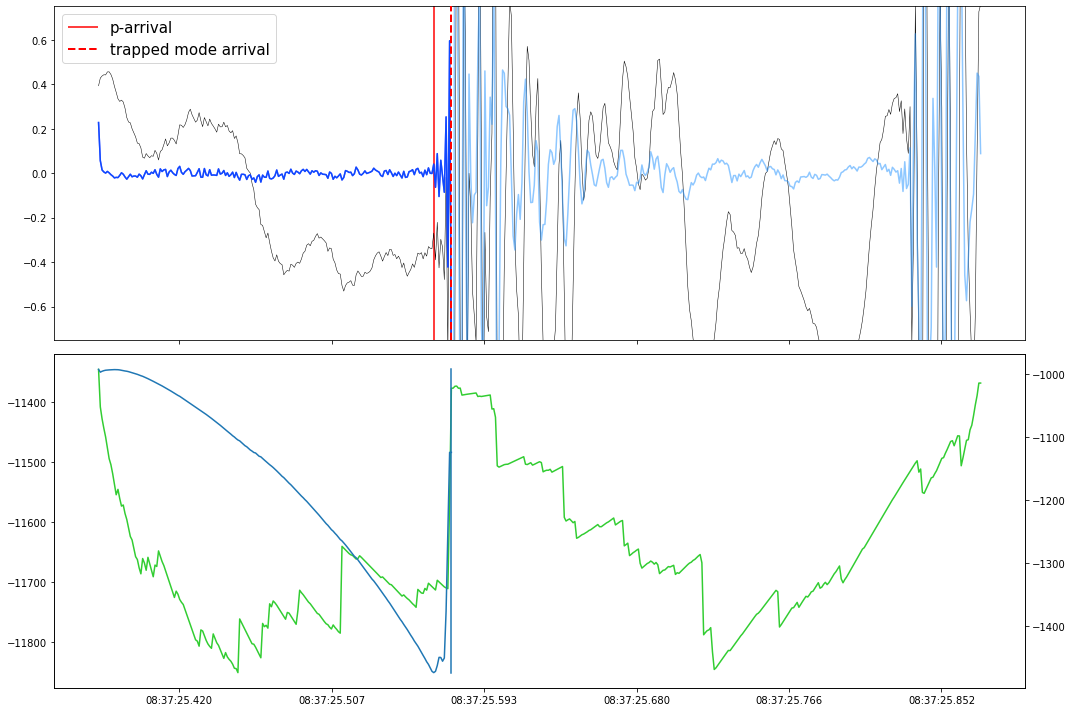

In [5]:
# event = df.iloc[1000]
event = df.iloc[2200]
starttime = obspy.UTCDateTime(pd.to_datetime(event.first_arrival))
# need to make this conform to the aic data
window_start = starttime - 0.2
window_end = starttime + 0.3

window = waveforms.copy().trim(starttime=window_start, endtime=window_end)
raw = window.copy()
window.filter(type='bandpass', freqmin=200, freqmax=500, zerophase=False, corners=1)

p_waveforms = window.copy()
endtime = obspy.UTCDateTime(dates.num2date(event.arrival_time))
p_waveforms.trim(starttime=window_start, endtime=endtime)

fig, ax = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

for n, tr in enumerate(raw[event.first_hydrophone:]):
    ax[n].plot(tr.times('matplotlib'), tr.data, color='black', linewidth=0.5)
    break

for n, tr in enumerate(p_waveforms[event.first_hydrophone:]):
    ax[n].plot(tr.times('matplotlib'), tr.data, color='blue', linewidth=1.5)
    break
    
for n, tr in enumerate(window[event.first_hydrophone:]):
    ax[n].plot(tr.times('matplotlib'), tr.data, color='dodgerblue', linewidth=1.5, alpha=0.5)
    break

ax[1].plot(window[event.first_hydrophone].times('matplotlib'), event.aics, color='limegreen')


ax[1].xaxis.set_major_formatter(plotting.PrecisionDateFormatter("%H:%M:%S.{ms}"))

ax[1].plot((event.arrival_time, event.arrival_time), (min(event.aics), max(event.aics)))

ax2 = ax[1].twinx()
aic2 = trigger.aic_simple(p_waveforms[event.first_hydrophone])
t = p_waveforms[event.first_hydrophone].times('matplotlib')
ax2.plot(t, aic2)


# ax[1].set_xlim(event.first_arrival, event.arrival_time)

parrival = t[np.argmin(aic2)]

ax[0].vlines(x=parrival, ymin=-0.75, ymax=0.75, color='red', label='p-arrival')
ax[0].vlines(x=event.arrival_time, ymin=-0.75, ymax=0.75, color='red', label='trapped mode arrival', linewidth=2, zorder=20, linestyle='--')

# ax[0].set_xlim([starttime+0.05, endtime])
ax[0].set_ylim(-0.75, 0.75)
ax[0].legend(fontsize=15)

fig.tight_layout()

# you can make this more sophisticated, make it find all the peaks in the aic curve then pick the earliest peak, and you know you can control the onset window a bit as well


/home/john/anaconda3/envs/borehole/lib/python3.8/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (500) of bandpass is at or above Nyquist (500.0). Applying a high-pass instead.
  warnings.warn(msg)


380
17.30200494162454


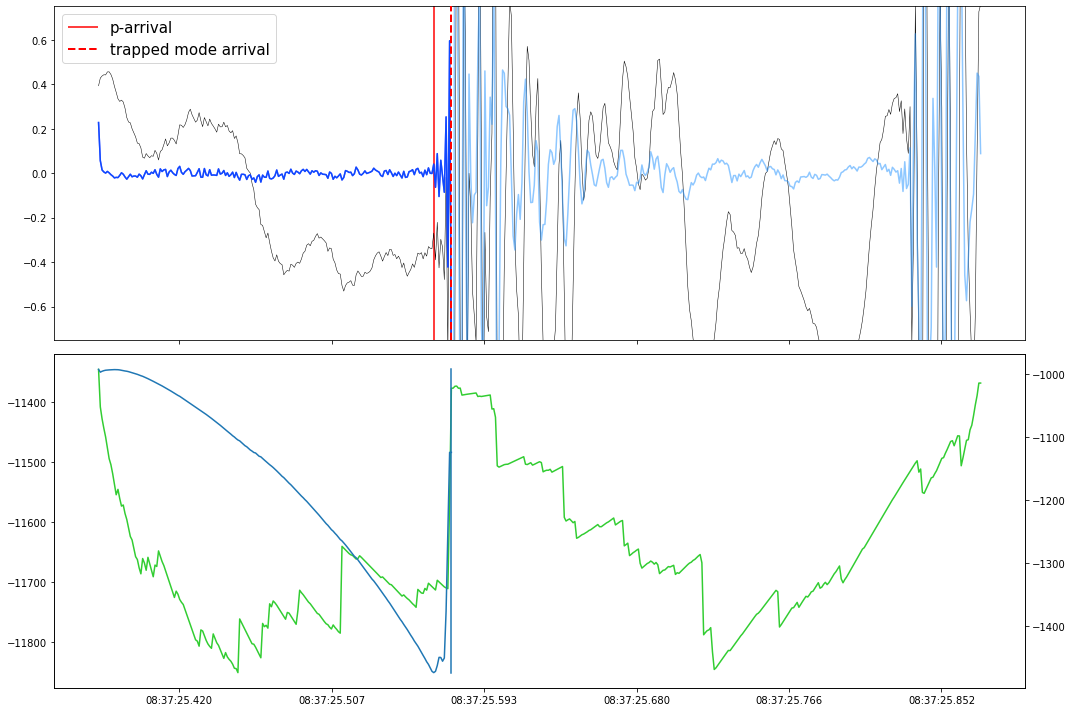

In [25]:
# event = df.iloc[1000]
event = df.iloc[2200]
starttime = obspy.UTCDateTime(pd.to_datetime(event.first_arrival))
# need to make this conform to the aic data
window_start = starttime - 0.2
window_end = starttime + 0.3

window = waveforms.copy().trim(starttime=window_start, endtime=window_end)
raw = window.copy()
window.filter(type='bandpass', freqmin=200, freqmax=500, zerophase=False, corners=1)

p_waveforms = window.copy()
endtime = obspy.UTCDateTime(dates.num2date(event.arrival_time))
p_waveforms.trim(starttime=window_start, endtime=endtime)

aic2 = trigger.aic_simple(p_waveforms[event.first_hydrophone])
t = p_waveforms[event.first_hydrophone].times('matplotlib')
parrival = t[np.argmin(aic2)]

parrival_t = dates.num2date(parrival)
mode_t = dates.num2date(event.arrival_time)

(mode_t - parrival_t).total_seconds()
# event.velocity_model**2 * (mode_t - parrival_t).total_seconds()**2
1750**2 * (mode_t - parrival_t).total_seconds()**2

# relative_depth = event.depth - 310
print(hydrophone_metadata['h'+str(event.first_hydrophone+1)]['depth'])
relative_depth = event.depth - hydrophone_metadata['h'+str(event.first_hydrophone+1)]['depth']
# np.sqrt(1750**2 * (mode_t - parrival_t).total_seconds()**2 - relative_depth**2)

# should i be using absolute value?
radius = np.sqrt(abs(1750**2 * (mode_t - parrival_t).total_seconds()**2 - relative_depth**2))
print(radius)

fig, ax = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

for n, tr in enumerate(raw[event.first_hydrophone:]):
    ax[n].plot(tr.times('matplotlib'), tr.data, color='black', linewidth=0.5)
    break

for n, tr in enumerate(p_waveforms[event.first_hydrophone:]):
    ax[n].plot(tr.times('matplotlib'), tr.data, color='blue', linewidth=1.5)
    break
    
for n, tr in enumerate(window[event.first_hydrophone:]):
    ax[n].plot(tr.times('matplotlib'), tr.data, color='dodgerblue', linewidth=1.5, alpha=0.5)
    break

ax[1].plot(window[event.first_hydrophone].times('matplotlib'), event.aics, color='limegreen')


ax[1].xaxis.set_major_formatter(plotting.PrecisionDateFormatter("%H:%M:%S.{ms}"))

ax[1].plot((event.arrival_time, event.arrival_time), (min(event.aics), max(event.aics)))

ax2 = ax[1].twinx()

ax2.plot(t, aic2)


# ax[1].set_xlim(event.first_arrival, event.arrival_time)


ax[0].vlines(x=parrival, ymin=-0.75, ymax=0.75, color='red', label='p-arrival')
ax[0].vlines(x=event.arrival_time, ymin=-0.75, ymax=0.75, color='red', label='trapped mode arrival', linewidth=2, zorder=20, linestyle='--')

# ax[0].set_xlim([starttime+0.05, endtime])
ax[0].set_ylim(-0.75, 0.75)
ax[0].legend(fontsize=15)

fig.tight_layout()

# you can make this more sophisticated, make it find all the peaks in the aic curve then pick the earliest peak, and you know you can control the onset window a bit as well


In [6]:
# todo: do a pythagorean theorem distance calculation here
parrival_t = dates.num2date(parrival)
mode_t = dates.num2date(event.arrival_time)

(mode_t - parrival_t).total_seconds()
1750**2 * (mode_t - parrival_t).total_seconds()**2

306.25

In [26]:
relative_depth = event.depth - 380
# np.sqrt(1750**2 * (mode_t - parrival_t).total_seconds()**2 - relative_depth**2)

# should i be using absolute value?
np.sqrt(abs(1750**2 * (mode_t - parrival_t).total_seconds()**2 - relative_depth**2))

17.30200494162454

In [19]:
# TODO : calculate radius for all values and plot along with depth
event.depth

377.375

In [20]:
np.sqrt(abs(150.0625 - 275.125))

11.18313462317252

In [21]:
hydrophone_metadata['h4']

{'start': 2019-05-21T07:48:00.000000Z,
 'end': 2019-05-21T08:07:00.000000Z,
 'obspy_idx': 3,
 'depth': 240,
 'velocity_model': 1750}

In [22]:
event

Unnamed: 0                                                        2200
id                                                                2200
depth                                                          377.375
aic_t                [18037.35932378472, 18037.359323773147, 18037....
aics                 [-11345.921431981316, -11408.354218364839, -11...
aic_maxes                               [199, 198, 343, 281, 236, 199]
first_hydrophone                                                     5
second_hydrophone                                                    4
arrival_time                                              18037.359324
first_arrival                         2019-05-21 08:37:25.575000+00:00
second_arrival                        2019-05-21 08:37:25.612000+00:00
dt                                                              -0.037
Name: 2200, dtype: object